In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib  inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [7]:
g = torch.Generator().manual_seed(5462384)
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos, vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 27


In [8]:
# build the dataset
block_size = 3 # how many characters do we take to predict next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [25]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_out, fan_in), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight.T
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # parameters (trained with backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        # buffers (trained with 'momentum update')

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            # calculate the mean and variance of the current batch
            xmean = x.mean(dim=0, keepdim=True) # batch mean
            xvar = x.var(dim=0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # scale and shift
        # update the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10 # dimentinality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP


C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of 5/3
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters)) # total number of parameters


for p in parameters:
    p.requires_grad = True

46227


In [26]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vectors 
    x  = emb.view(emb.shape[0], -1) # concatenete the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # upadate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():4f}')

    lossi.append(loss.log10().item())

    break

      0 /  200000: 3.295606


layer 1 (      Tanh): mean -0.02, std 0.79, saturated: 28.28%
layer 3 (      Tanh): mean -0.01, std 0.71, saturated: 13.00%
layer 5 (      Tanh): mean -0.02, std 0.69, saturated: 8.09%
layer 7 (      Tanh): mean -0.01, std 0.67, saturated: 6.97%
layer 9 (      Tanh): mean -0.02, std 0.65, saturated: 5.22%


Text(0.5, 1.0, 'activation distribution')

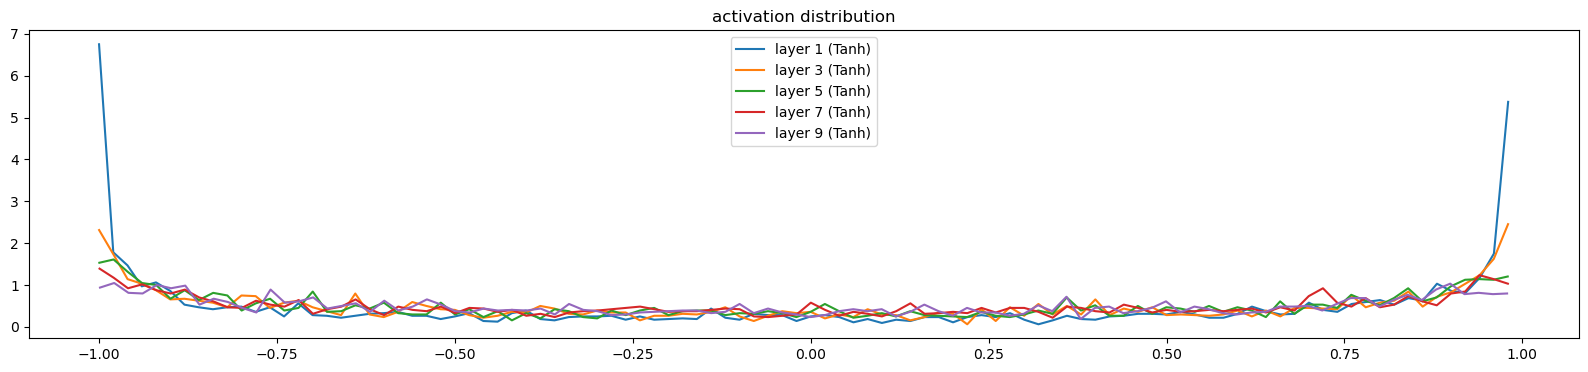

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000002, std 3.975341e-04
layer 3 (      Tanh): mean +0.000002, std 3.858430e-04
layer 5 (      Tanh): mean +0.000012, std 3.742945e-04
layer 7 (      Tanh): mean -0.000001, std 3.465930e-04
layer 9 (      Tanh): mean +0.000009, std 3.135965e-04


Text(0.5, 1.0, 'gradient distribution')

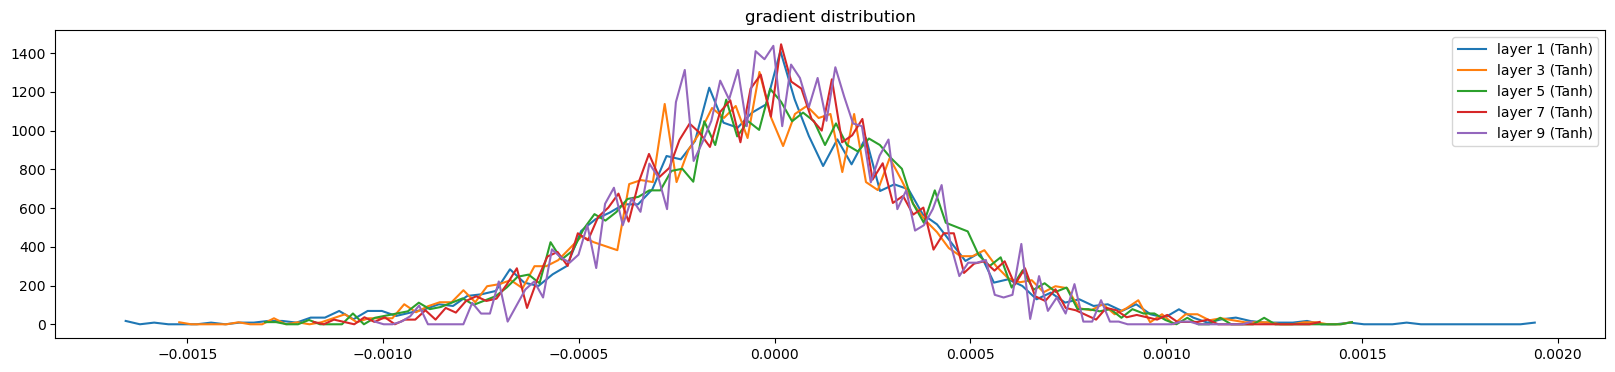

In [28]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

In [107]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd  = hpreact.std(dim=0, keepdim=True)

In [116]:
@torch.no_grad()
def split_loss(split):
    x, y =  {
        'train': (Xtr, Ytr), 
        'val':   (Xdev, Ydev), 
        'test':   (Xte, Xte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngains * (hpreact -  bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    losits = h @ W2 + b2
    loss = F.cross_entropy(losits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.161543369293213
val 2.1825852394104004
